# ENV CHECK (embeddings + multiprocessing)

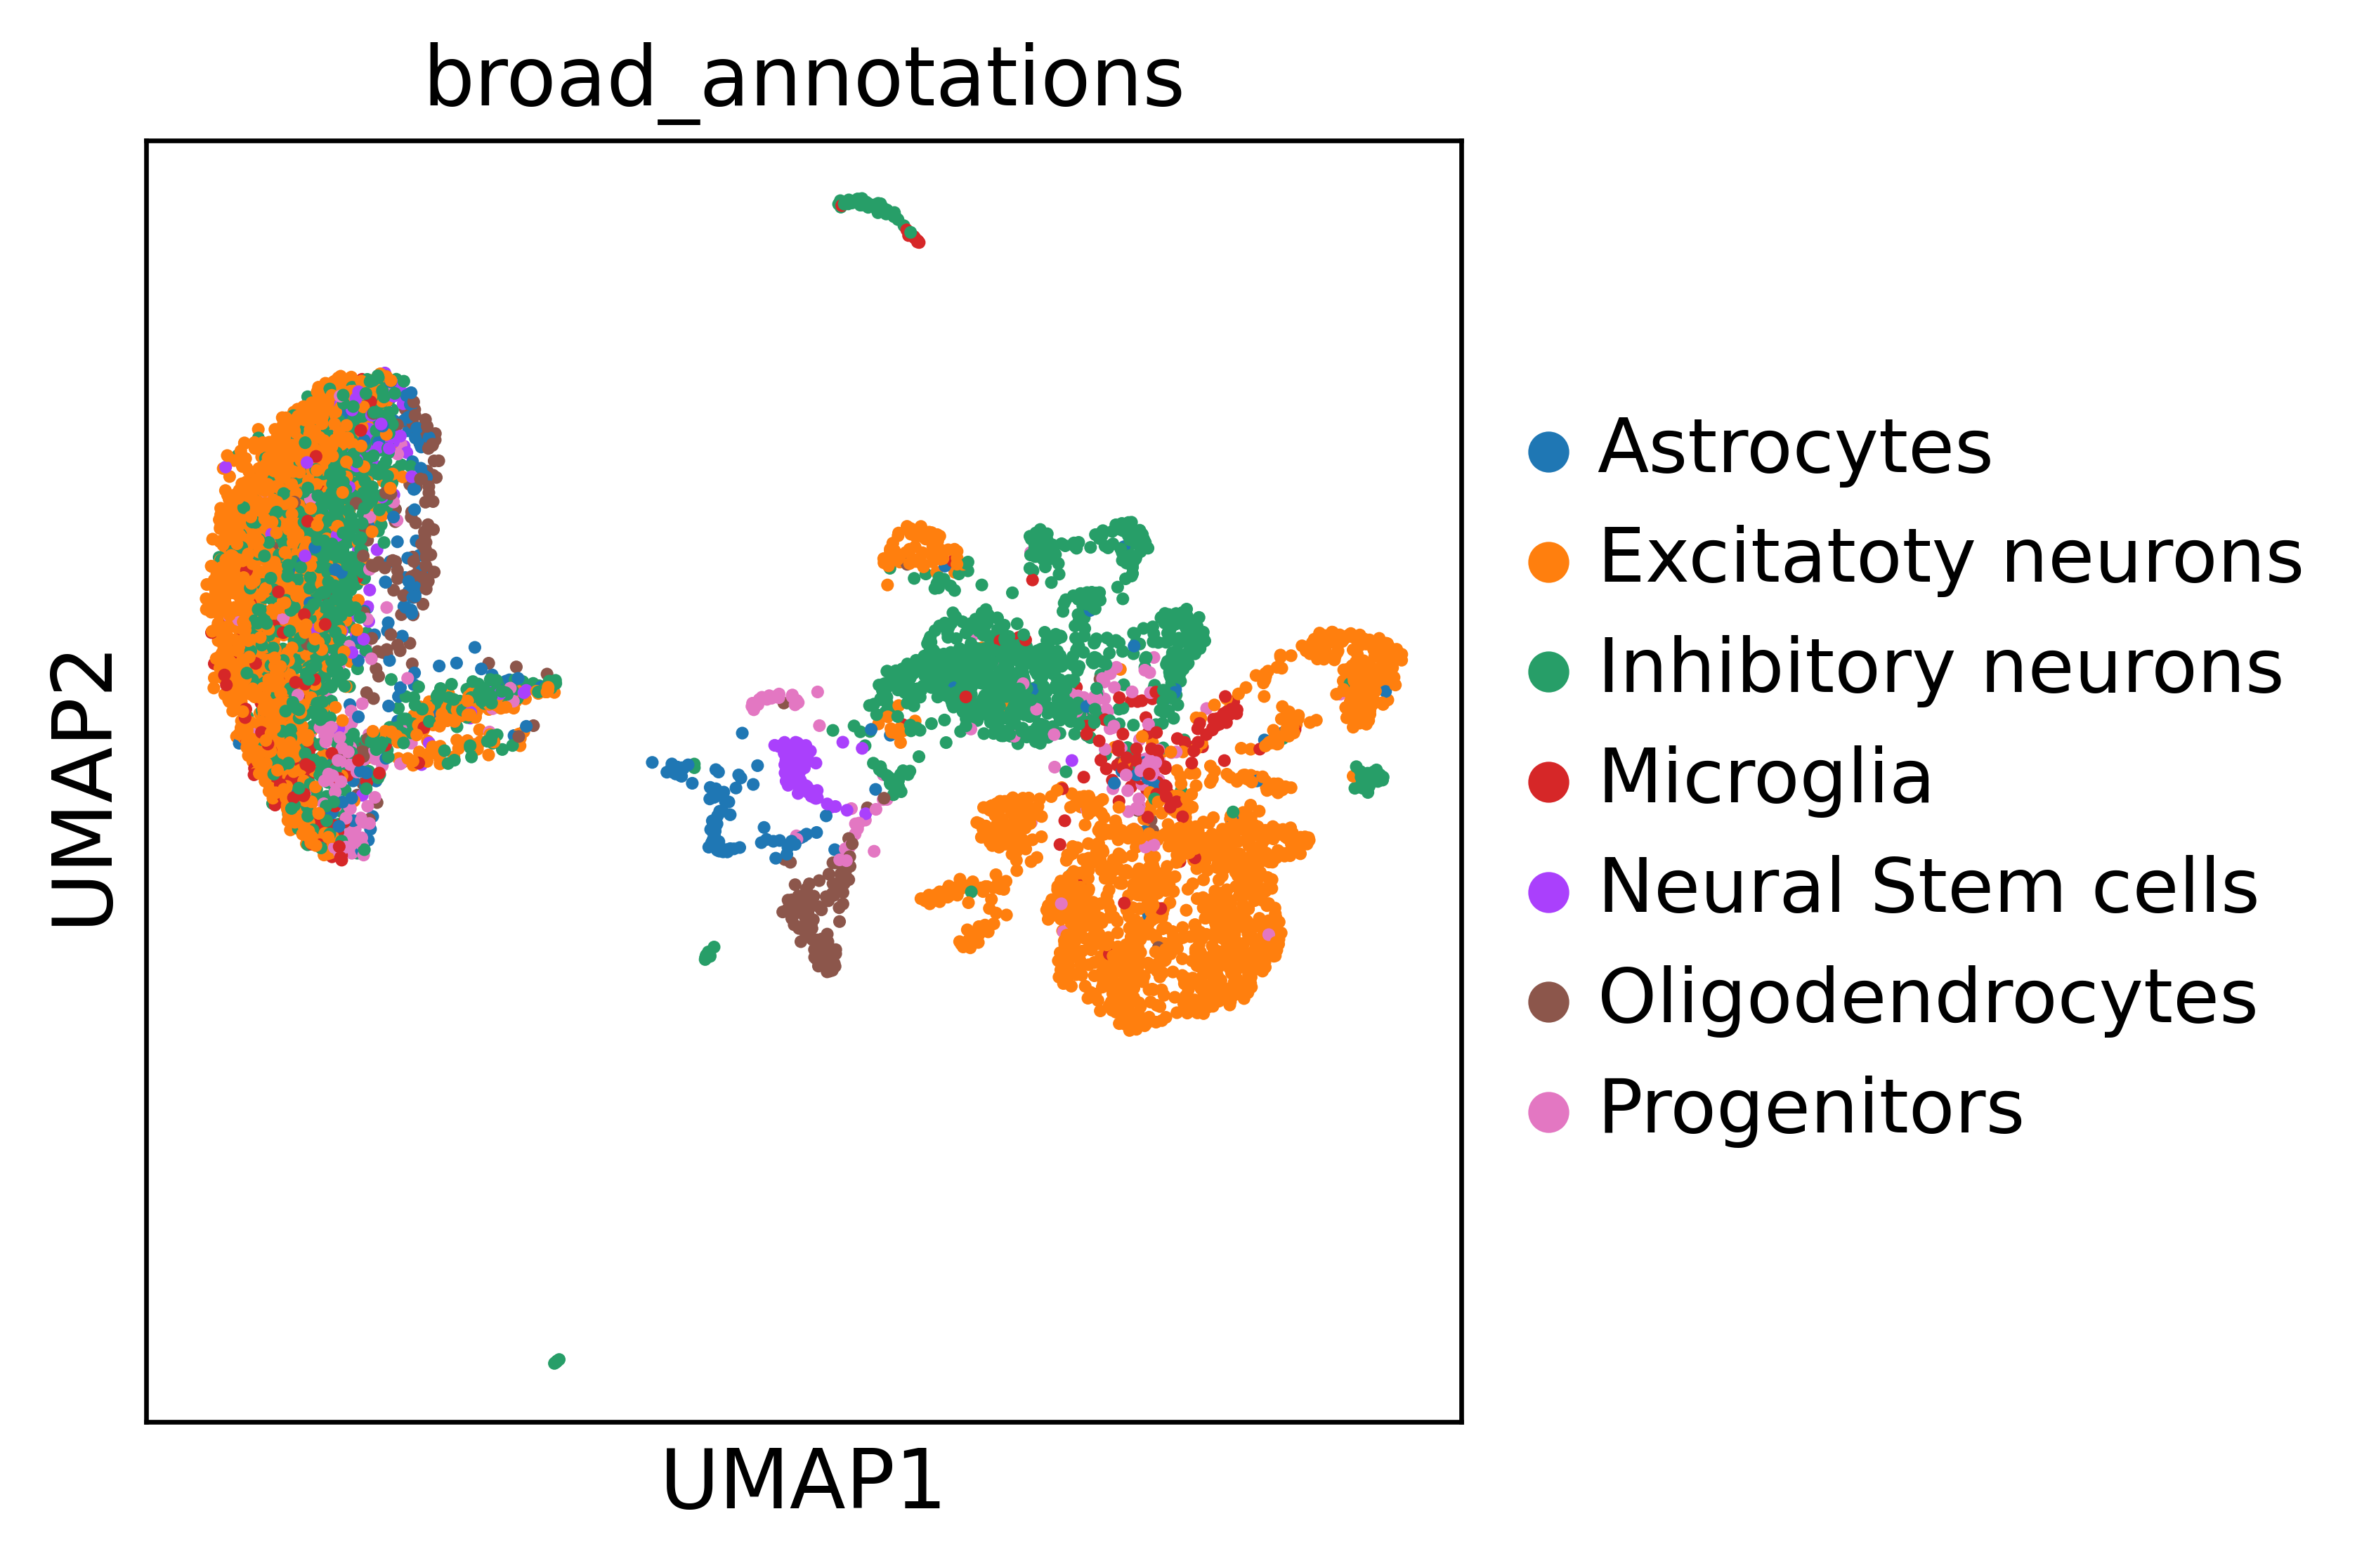

In [1]:
# figure settings
import scanpy as sc
import anndata as ad
import os
sc.set_figure_params(scanpy=True, dpi=300, dpi_save=600,
                     frameon=True, vector_friendly=True,
                     color_map="YlGnBu", format='pdf', transparent=False,
                     ipython_format='png2x')

DATADIR = "/storage/groups/ce01/workspace/mobisc_anna/processed_datasets/share_seq_brain"
#%ls $DATADIR
files = [os.path.join(DATADIR, 'old_anndata_brain_share_seq_geneactivity_rna_merged.h5ad')]

int_files = ['liger_jnmf_integration.h5ad', 
             'scJoint_integration.h5ad', 
             'seurat_cca_integration.h5ad', 
             'seurat_rpca_integration.h5ad']

DATADIR = "/storage/groups/ce01/workspace/mobisc_anna/integrated_outputs/share_seq_brain_shared_genes_full"
#%ls $DATADIR
for i in int_files:
    files.append(os.path.join(DATADIR, i))
    
data = ad.read(files[0])
sc.pp.pca(data)
sc.pp.neighbors(data)
sc.tl.umap(data)
sc.pl.umap(data, color='broad_annotations')

from multiprocessing import Process, Queue
from time import sleep


def my_func(n, l):
    if n % 2 == 0:
        sleep(5)
    for i in l:
        print(f'Process {n}: {i}\n')
    
processes = []
my_list = range(1, 5)
for i in range(8):
    p = Process(target=my_func, args=(i, my_list))
    p.start()
    processes.append(p)
    
for p in processes:
    p.join()

# FURTHER ANALYSIS

In [2]:
# Load packages 
import scanpy as sc
import anndata as ad
import os
import pandas as pd
import matplotlib.pyplot as plt
import scmoib
import numpy as np
import tqdm

During startup - Warning messages:
1: Setting LC_TIME failed, using "C" 
2: Setting LC_MONETARY failed, using "C" 
3: Setting LC_PAPER failed, using "C" 
4: Setting LC_MEASUREMENT failed, using "C" 


In [3]:
# figure settings
sc.set_figure_params(scanpy=True, dpi=80, dpi_save=250,
                     frameon=True, vector_friendly=True,
                     color_map="YlGnBu", format='pdf', transparent=False,
                     ipython_format='png2x')

/home/icb/atai.dobrynin/miniconda3/envs/test2/lib/python3.7/site-packages/scanpy/_settings.py:447: DeprecationWarning:

`set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`



## Load the processed data

In [4]:
DATADIR = "/storage/groups/ce01/workspace/mobisc_anna/processed_datasets/share_seq_brain"
#%ls $DATADIR
files = [os.path.join(DATADIR, 'old_anndata_brain_share_seq_geneactivity_rna_merged.h5ad')]

int_files = ['liger_jnmf_integration.h5ad', 
             'scJoint_integration.h5ad', 
             'seurat_cca_integration.h5ad', 
             'seurat_rpca_integration.h5ad']

DATADIR = "/storage/groups/ce01/workspace/mobisc_anna/integrated_outputs/share_seq_brain_shared_genes_full"
#%ls $DATADIR
for i in int_files:
    files.append(os.path.join(DATADIR, i))
    
ids = ['unintegrated', 'liger', 'scjoint', 'seurat_cca', 'seurat_rpca']
modes = ['raw', 'comps', 'comps', 'count', 'count']
col = ['broad_annotations'] * 5
reps = [None, 'X_inmf_embedding', 'X_scjoint_embedding', None, None]
my_obj = scmoib.tl.MetricsCalculator()
adata_list = []

DATADIR = "/mnt/znas/icb_zstore01/groups/ce01/workspace/mobisc_anna/processed_datasets/PBMC_10X/"
#%ls $DATADIR
files = [os.path.join(DATADIR, 'old_anndata_pbmc_10x_processed_merged_rna_first_full_feature.h5ad')]

int_files = ['liger/PBMC_10X_jNMF.h5ad', 
             'seurat_cca/pbmc_10x_seurat_cca_rna_first.h5ad', 
             'bindsc/pbmc_10x_bindsc_rna_first_full_feature.h5ad', 
             'scalex/RNA-ATAC_pbmc_10x_scalex_processed_full_feature.h5ad', 
             'seurat_rpca/pbmc_10x_seurat_rpca_rna_first.h5ad']

DATADIR = "/storage/groups/ce01/workspace/mobisc_anna/integrated_outputs/"
%ls $DATADIR
for i in int_files:
    files.append(os.path.join(DATADIR, i))
    
ids = ['unintegrated', 'liger', 'seurat_cca', 'bindsc', 'scalex', 'seurat_rpca']
modes = ['raw', 'comps', 'count', 'count', 'graph', 'count']
col = ['broad cell types', 'broad.cell.types'] + ['broad cell types'] * 4
reps = [None, 'X_iNMF', None, None, None, None]
my_obj = scmoib.tl.MetricsCalculator()
adata_list = []

In [5]:
%%time


for i in tqdm.tqdm(files):
    pbmc = ad.read(i)
    adata_id = ids[files.index(i)]
    clust_id = 'louvain'
    ct_id = col[files.index(i)]
    bc_list = list(pbmc.obs.index)
    bc_list1 = bc_list[:len(bc_list) // 2]
    bc_list2 = bc_list[len(bc_list) // 2:]
    mode = modes[files.index(i)]
    rep = reps[files.index(i)]
    my_obj.check_anndata(pbmc, ct_id, mode=mode, use_rep=rep)
    print('-' * 10)
    my_obj.node_metrics(pbmc, adata_id, bc_list1, bc_list2, ct_id, n_jobs=8)
    my_obj.spec_dist(pbmc, adata_id=adata_id, n_metr=10)
    try:
        my_obj._accuracy_paired_omics(pbmc, adata_id, bc_list1, bc_list2, 'omic_batch', clust_id)
        my_obj._accuracy_paired_omics_per_cell_type(pbmc, adata_id, bc_list1, bc_list2, 
                                                    'omic_batch', clust_id, ct_id)
        my_obj.ami(pbmc, adata_id, ct_id, clust_id)
        my_obj.ari(pbmc, adata_id, ct_id, clust_id)
        my_obj.nmi(pbmc, adata_id, ct_id, clust_id)
        my_obj.homogeneity(pbmc, adata_id, ct_id, clust_id)
    
    except ValueError as err:
        print(f"Trouble with {adata_id}")
        print(err.args[0])

    my_obj._graph_connectivity(pbmc, adata_id, ct_id)
    try:
        my_obj.silhouette(pbmc, adata_id, batch_key='omic_batch', embed='X_umap')
        my_obj.silhouette_batch(pbmc, adata_id, batch_key='omic_batch', cell_label=ct_id, embed='X_umap')
    except:
        print('Silhouette failed')
    my_obj._average_dist_between_matching_barcodes(pbmc, adata_id, bc_list1, bc_list2, metric='cosine')
    my_obj.isolated_labels_score(pbmc, adata_id, ct_id, 'omic_batch', 'X_umap')
    adata_list.append(pbmc)
my_obj.get_df()

  0%|                                                     | 0/5 [00:00<?, ?it/s]

Running pre-flight check


/home/icb/atai.dobrynin/miniconda3/envs/test2/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.



Clustering...
step 0
got 23 at resolution 1.5
step 1
got 17 at resolution 0.75
step 2
got 12 at resolution 0.375
step 3
got 8 at resolution 0.1875
step 4
got 3 at resolution 0.09375
step 5
got 5 at resolution 0.140625
step 6
got 6 at resolution 0.1640625
step 7
got 7 at resolution 0.17578125
----------


/home/icb/atai.dobrynin/miniconda3/envs/test2/lib/python3.7/site-packages/scmoib-0.0.1+7.gfe906bc.dirty-py3.7.egg/scmoib/tools/metrics/utils/dijkstra.py:137: UserWarning:

Warning! You are running the high load graph method.
Test run information:
CPU: 8 cores
Wall time: 6 minutes
RAM: 4 GB(?)
Number of barcode pairs: 11k

/home/icb/atai.dobrynin/miniconda3/envs/test2/lib/python3.7/site-packages/scib-1.0.0-py3.7.egg/scib/metrics/isolated_labels.py:57: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

 20%|█████████                                    | 1/5 [01:27<05:49, 87.48s/it]

Running pre-flight check
Clustering...
step 0
got 22 at resolution 1.5
step 1
got 12 at resolution 0.75
step 2
got 7 at resolution 0.375
----------


/home/icb/atai.dobrynin/miniconda3/envs/test2/lib/python3.7/site-packages/scmoib-0.0.1+7.gfe906bc.dirty-py3.7.egg/scmoib/tools/metrics/utils/dijkstra.py:137: UserWarning:

Warning! You are running the high load graph method.
Test run information:
CPU: 8 cores
Wall time: 6 minutes
RAM: 4 GB(?)
Number of barcode pairs: 11k

/home/icb/atai.dobrynin/miniconda3/envs/test2/lib/python3.7/site-packages/scib-1.0.0-py3.7.egg/scib/metrics/isolated_labels.py:57: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

 40%|██████████████████                           | 2/5 [02:47<04:08, 82.93s/it]

Running pre-flight check
Clustering...
step 0
got 15 at resolution 1.5
step 1
got 10 at resolution 0.75
step 2
got 6 at resolution 0.375
step 3
got 10 at resolution 0.5625
step 4
got 9 at resolution 0.46875
step 5
got 8 at resolution 0.421875
step 6
got 7 at resolution 0.3984375
----------


/home/icb/atai.dobrynin/miniconda3/envs/test2/lib/python3.7/site-packages/scmoib-0.0.1+7.gfe906bc.dirty-py3.7.egg/scmoib/tools/metrics/utils/dijkstra.py:137: UserWarning:

Warning! You are running the high load graph method.
Test run information:
CPU: 8 cores
Wall time: 6 minutes
RAM: 4 GB(?)
Number of barcode pairs: 11k

/home/icb/atai.dobrynin/miniconda3/envs/test2/lib/python3.7/site-packages/scib-1.0.0-py3.7.egg/scib/metrics/isolated_labels.py:57: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

 60%|███████████████████████████                  | 3/5 [04:04<02:40, 80.23s/it]

Running pre-flight check


/home/icb/atai.dobrynin/miniconda3/envs/test2/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.



Clustering...
step 0
got 29 at resolution 1.5
step 1
got 20 at resolution 0.75
step 2
got 13 at resolution 0.375
step 3
got 11 at resolution 0.1875
step 4
got 9 at resolution 0.09375
step 5
got 7 at resolution 0.046875
----------


/home/icb/atai.dobrynin/miniconda3/envs/test2/lib/python3.7/site-packages/scmoib-0.0.1+7.gfe906bc.dirty-py3.7.egg/scmoib/tools/metrics/utils/dijkstra.py:137: UserWarning:

Warning! You are running the high load graph method.
Test run information:
CPU: 8 cores
Wall time: 6 minutes
RAM: 4 GB(?)
Number of barcode pairs: 11k

/home/icb/atai.dobrynin/miniconda3/envs/test2/lib/python3.7/site-packages/scib-1.0.0-py3.7.egg/scib/metrics/isolated_labels.py:57: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

 80%|████████████████████████████████████         | 4/5 [05:11<01:14, 74.99s/it]

Running pre-flight check


/home/icb/atai.dobrynin/miniconda3/envs/test2/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.



Clustering...
step 0
got 31 at resolution 1.5
step 1
got 18 at resolution 0.75
step 2
got 15 at resolution 0.375
step 3
got 10 at resolution 0.1875
step 4
got 6 at resolution 0.09375
step 5
got 8 at resolution 0.140625
step 6
got 9 at resolution 0.1171875
step 7
got 7 at resolution 0.10546875
----------


/home/icb/atai.dobrynin/miniconda3/envs/test2/lib/python3.7/site-packages/scmoib-0.0.1+7.gfe906bc.dirty-py3.7.egg/scmoib/tools/metrics/utils/dijkstra.py:137: UserWarning:

Warning! You are running the high load graph method.
Test run information:
CPU: 8 cores
Wall time: 6 minutes
RAM: 4 GB(?)
Number of barcode pairs: 11k

/home/icb/atai.dobrynin/miniconda3/envs/test2/lib/python3.7/site-packages/scib-1.0.0-py3.7.egg/scib/metrics/isolated_labels.py:57: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

100%|█████████████████████████████████████████████| 5/5 [06:16<00:00, 75.24s/it]

CPU times: user 30min 50s, sys: 8min 12s, total: 39min 3s
Wall time: 6min 16s


,conn_ratio,spec_dist_10,accuracy,AMI,ARI,NMI,homogeneity,graph connectivity broad_annotations,sil_global,sil_clus,pairwise_distance,il_sil,il_clus
unintegrated,1.0,0.147571,0.000632,0.254587,0.121660,0.256195,0.260348,0.682698,0.838126,0.263867,0.834608,NaN,NaN
liger,1.0,1.000000,0.022440,0.231748,0.147377,0.233490,0.228258,0.844183,0.872103,0.177196,0.834608,NaN,NaN
scjoint,1.0,1.000000,0.461757,0.588411,0.521878,0.589200,0.660827,0.912184,0.521341,0.559623,0.834608,NaN,NaN
seurat_cca,1.0,0.849134,0.849874,0.084305,0.003070,0.087487,0.057767,0.895067,0.597320,0.694866,0.976174,NaN,NaN
seurat_rpca,1.0,0.795325,0.765171,0.094684,-0.026638,0.097519,0.070147,0.869876,0.640754,0.556388,0.983140,NaN,NaN


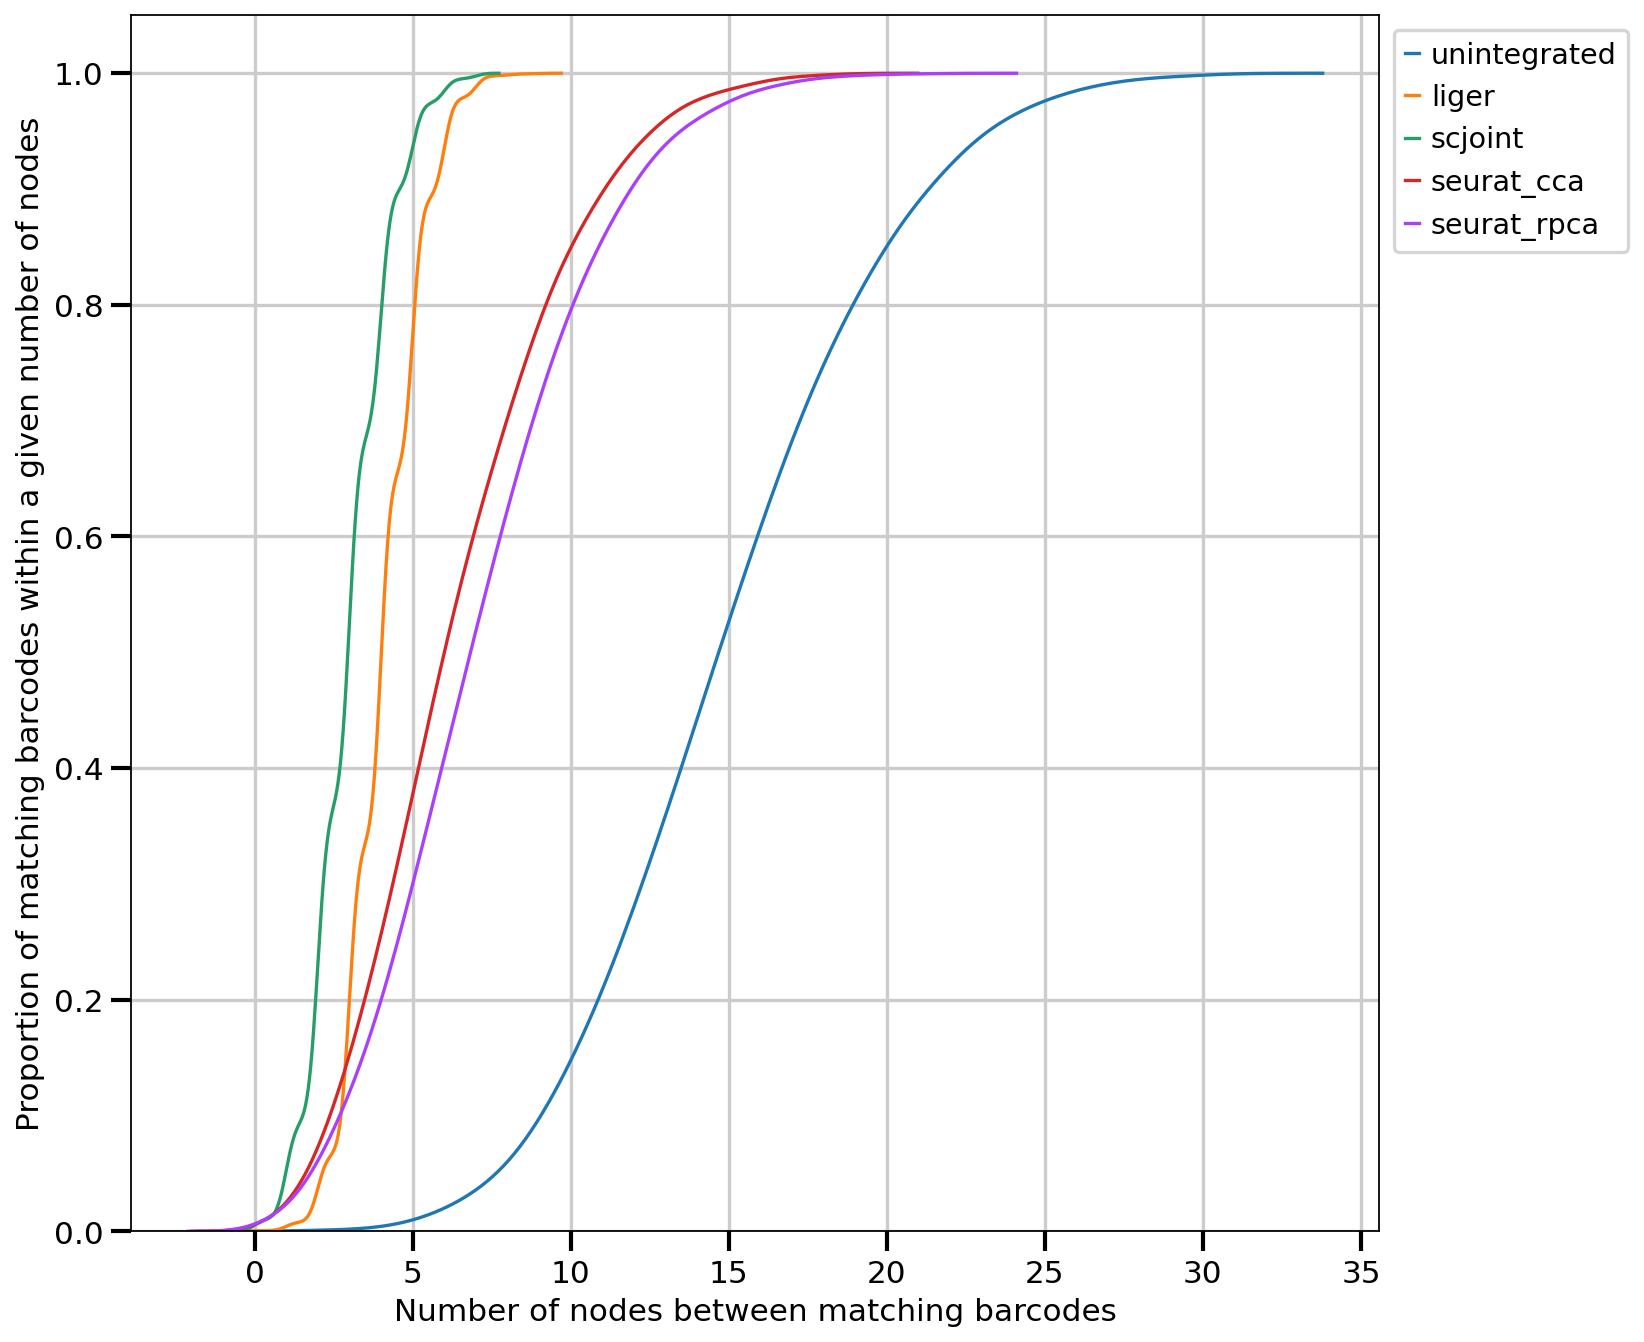

In [6]:
scmoib.pl.cumulative_node_group(adata_list, ids)

In [7]:
df = my_obj.get_df()
df

,conn_ratio,spec_dist_10,accuracy,AMI,ARI,NMI,homogeneity,graph connectivity broad_annotations,sil_global,sil_clus,pairwise_distance,il_sil,il_clus
unintegrated,1.0,0.147571,0.000632,0.254587,0.121660,0.256195,0.260348,0.682698,0.838126,0.263867,0.834608,NaN,NaN
liger,1.0,1.000000,0.022440,0.231748,0.147377,0.233490,0.228258,0.844183,0.872103,0.177196,0.834608,NaN,NaN
scjoint,1.0,1.000000,0.461757,0.588411,0.521878,0.589200,0.660827,0.912184,0.521341,0.559623,0.834608,NaN,NaN
seurat_cca,1.0,0.849134,0.849874,0.084305,0.003070,0.087487,0.057767,0.895067,0.597320,0.694866,0.976174,NaN,NaN
seurat_rpca,1.0,0.795325,0.765171,0.094684,-0.026638,0.097519,0.070147,0.869876,0.640754,0.556388,0.983140,NaN,NaN


In [8]:
df.drop(columns=['conn_ratio', 'il_clus', 'il_sil'], inplace=True)

In [9]:
df

,spec_dist_10,accuracy,AMI,ARI,NMI,homogeneity,graph connectivity broad_annotations,sil_global,sil_clus,pairwise_distance
unintegrated,0.147571,0.000632,0.254587,0.121660,0.256195,0.260348,0.682698,0.838126,0.263867,0.834608
liger,1.000000,0.022440,0.231748,0.147377,0.233490,0.228258,0.844183,0.872103,0.177196,0.834608
scjoint,1.000000,0.461757,0.588411,0.521878,0.589200,0.660827,0.912184,0.521341,0.559623,0.834608
seurat_cca,0.849134,0.849874,0.084305,0.003070,0.087487,0.057767,0.895067,0.597320,0.694866,0.976174
seurat_rpca,0.795325,0.765171,0.094684,-0.026638,0.097519,0.070147,0.869876,0.640754,0.556388,0.983140


In [10]:
scmoib.tl.metrics.ari(adata_list[-1], 'louvain', 'broad_annotations', )

-0.026637502814078493

In [11]:
df.sum(axis=1)

unintegrated    3.660291
liger           4.591402
scjoint         6.649830
seurat_cca      5.095063
seurat_rpca     4.846366
dtype: float64

unintegrated


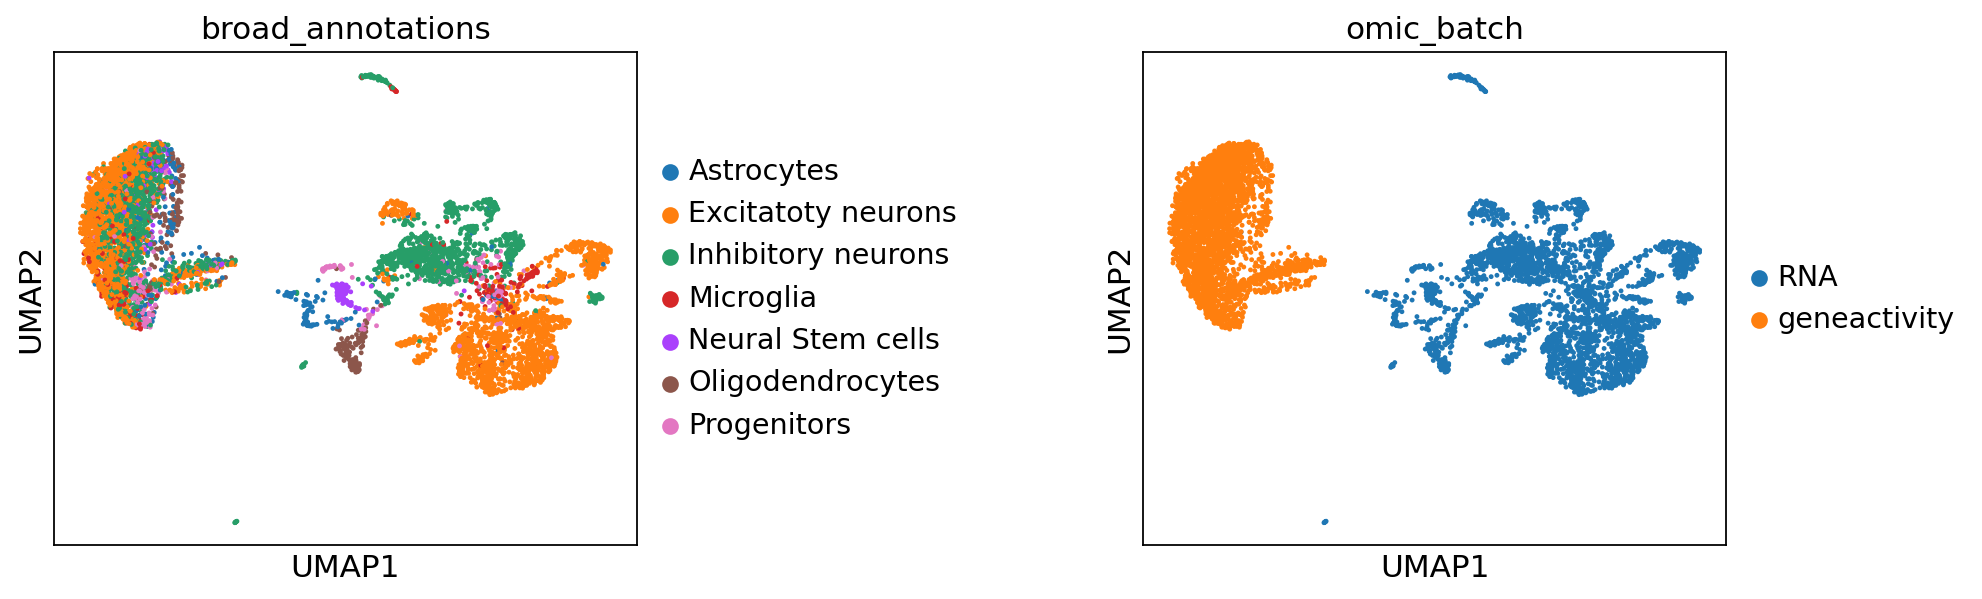

liger


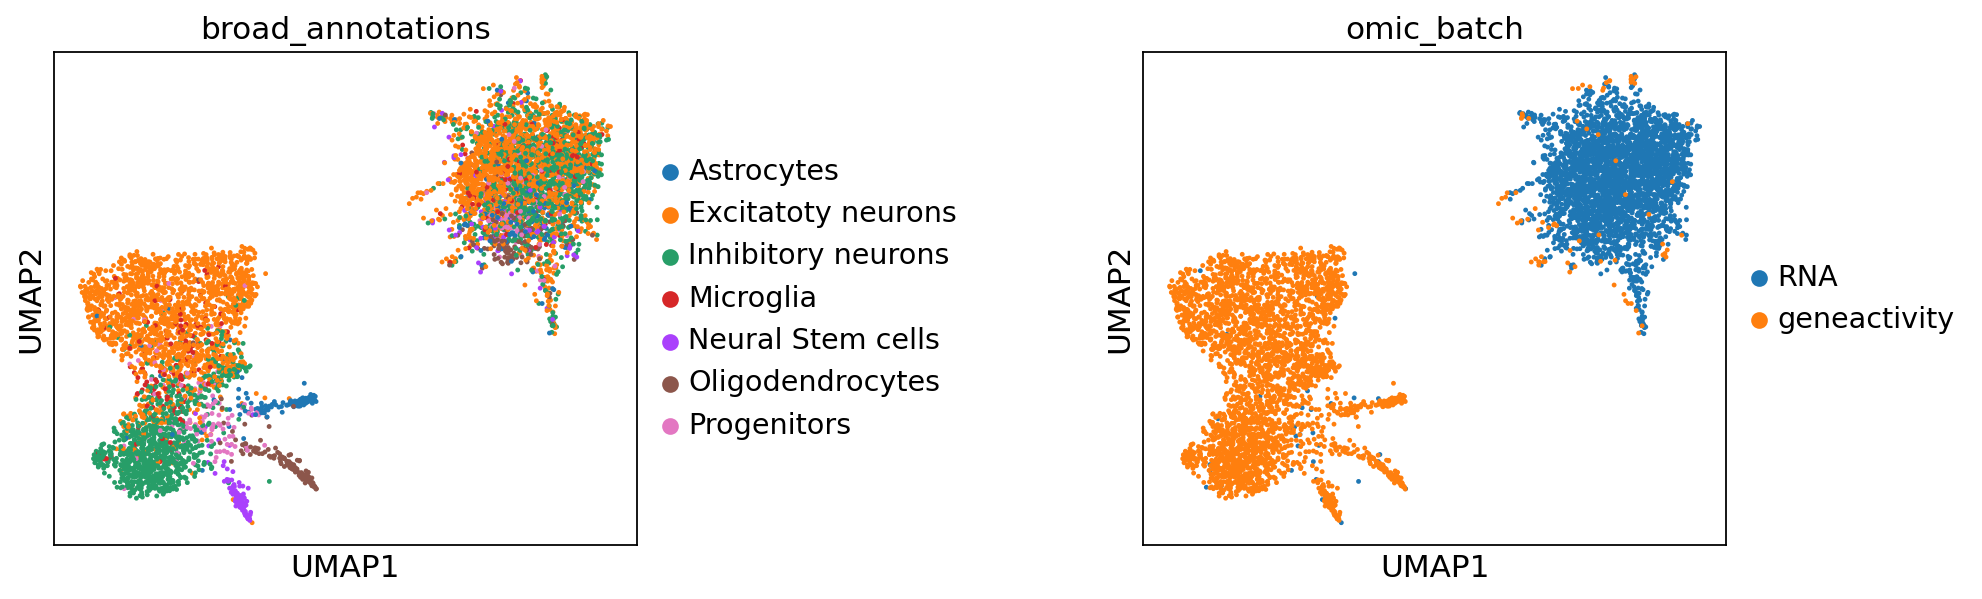

scjoint


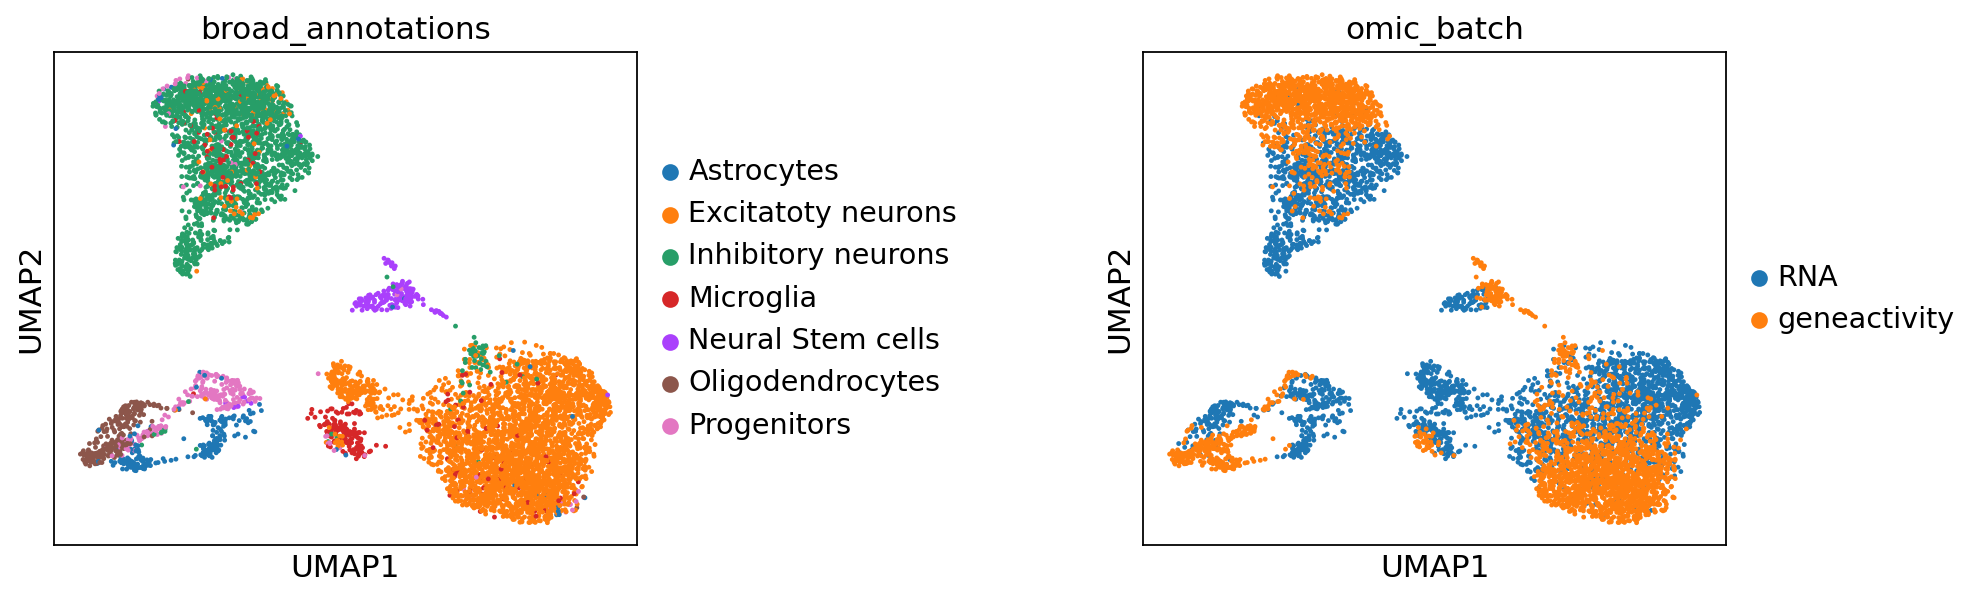

seurat_cca


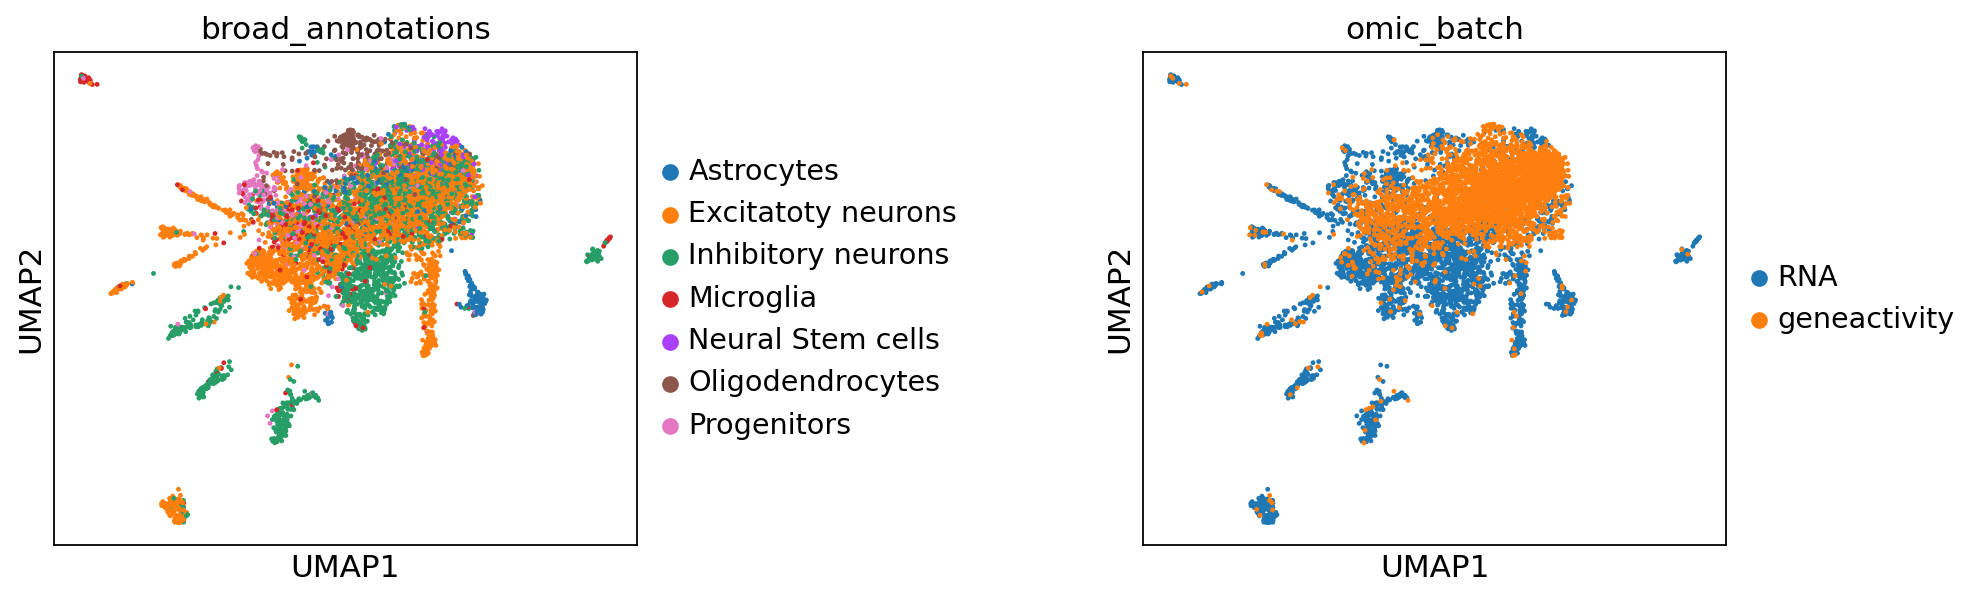

seurat_rpca


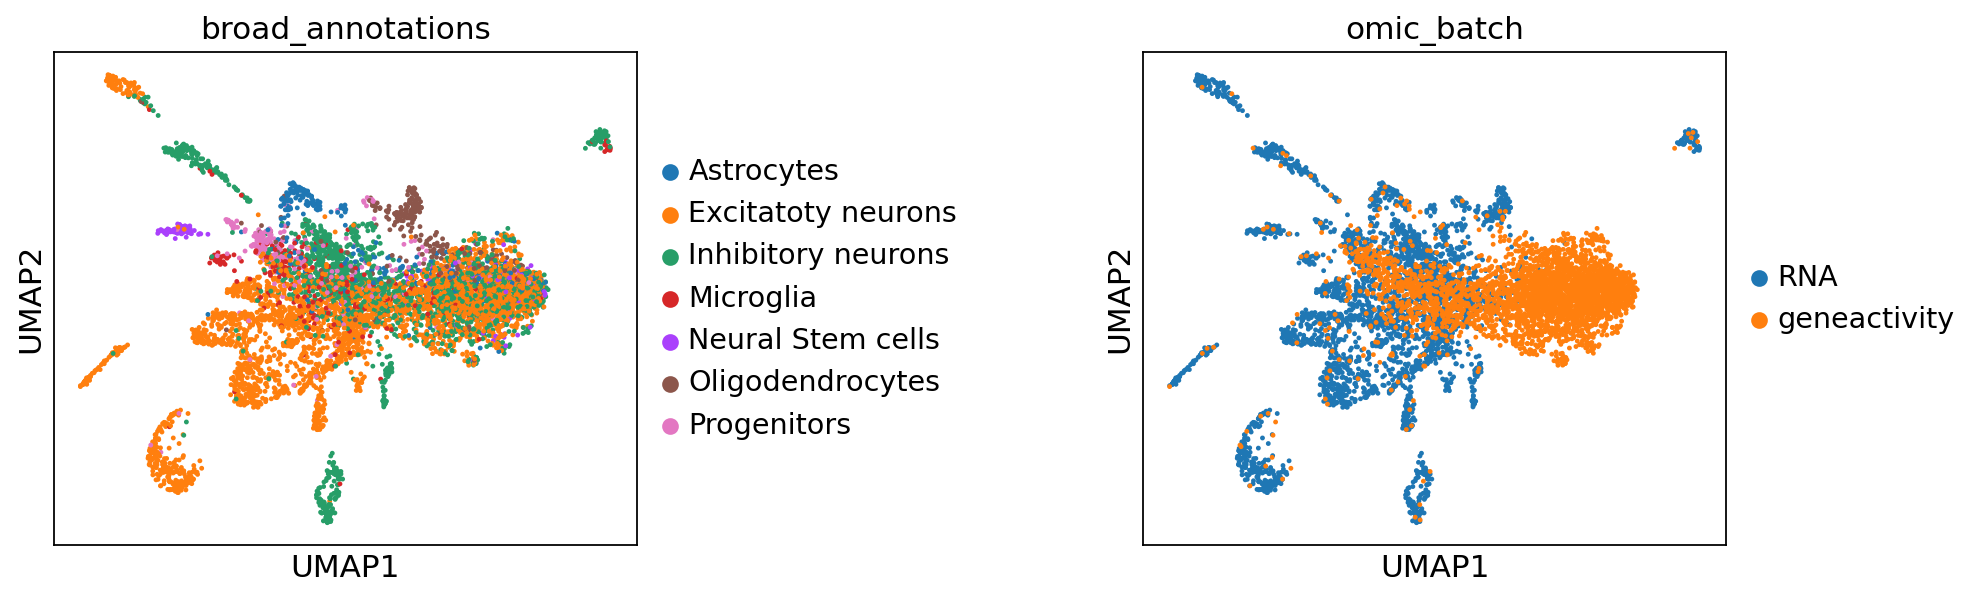

In [12]:
for i,j in zip(adata_list, ids):
    print(j)
    try:
        sc.pl.umap(i, color=['broad_annotations', 'omic_batch'], wspace=0.7)
    except:
        sc.pl.umap(i, color=['broad.cell.types', 'omic_batch'], wspace=0.7)